<a href="https://colab.research.google.com/github/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw9/hw9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW9. Operational Space Control**

The goal of HW 9 is to implement operational space controller on a 3 DoF openchain system described in the figure below, and investigate the tracking performance of various controllers. 

<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw8/3DoF_Arm_Kinematics.png?raw=true" height="400">
<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw8/3DoF_Arm_Dynamics.png?raw=true" height="400">


Given a desired position of the tip ${\mathbf r}_D^d = [x_d,\,y_d]^\top$, your **<font color='orange'>kinematics-based control law</font>** took the form:

\begin{equation}
\tau = J^T \left( K_p ({\mathbf r}_D^d - {\mathbf r}_D) + K_d (\dot{\mathbf r}_D^d - \dot{\mathbf r}_D) \right).
\end{equation} 

As we watched in the lecture, this method effectively controlled the end-effector position using a virtual spring-damper in the cartesian space. However, the Jacobian $J= \frac{\partial {\mathbf r}_D}{\partial q}$ was the only part of this control law that required information about the model! This homework will explore methods to improve the performance of the controller using more information about the model. Specifically, we will use information about its dynamics.

As we have seen in class, the dynamics of the leg are given by the **configuration-space** equations of motion:

\begin{equation} 
M(q) \ddot{q} + C(q,\dot{q}) + G(q) = \tau.
\end{equation} 


After a bit of algebraic manipulation, these equations can be rearranged into the **<font color='orange'>operational-space</font>** equations of motion to describe the dynamics of the end-effector: 

\begin{equation}
\Lambda(q)\, \ddot{\mathbf r}_C + \mu(q,\dot{q}) + \rho(q) = F,
\end{equation}

where $\Lambda(q)$ is the effective mass felt at the tip of arm, $\mu(q,\dot{q})$ gives the coriolis and centripetal forces on the tip, and $\rho(q)$ gives the gravity force felt on the tip. Formula for these quantities are given below:

\begin{align}
\Lambda(q)&= (J M^{-1} J^{T})^{-1} \\
\mu(q,\dot{q}) &= \Lambda J M^{-1}\, C - \Lambda \, \dot{J}\, \dot{q}\\
\rho(q) &= \Lambda J M^{-1}\, G
\end{align}

In this assignment, you will explore the use of an extended version of the kinematics-based controller **given** by:

\begin{equation}
\tau = J^{\top} \left[ \Lambda \left( \ddot{\mathbf r}_C^d + K ({\mathbf r}_C^d - {\mathbf r}_C) + D (\dot{\mathbf r}_C^d - \dot{\mathbf r}_C)\right) + \mu + \rho \right]\,.
\end{equation}


In [ ]:
# import useful libraries and clone class github
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
import dill
import os
!git clone https://github.com/DARoSLab/CS403-Intro-Robotics
func_path =  '/content/CS403-Intro-Robotics/hws/hw9/functions/'

%matplotlib inline


fatal: destination path 'CS403-Intro-Robotics' already exists and is not an empty directory.


In [ ]:
from re import X
# 3 dof arm visualization function: 
def visualize_arm(keypoints_hist, xee_des=None, dt = 0.001, num_frames=200):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)
  ax.grid()
  keypoints = keypoints_hist[0]
  link1, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  link2, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  link3, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  if xee_des is not None:
    target, = ax.plot(xee_des[:, 0], xee_des[:, 1], 'o', label='target')

  txt_title = ax.set_title('')
  
  ax.set_xlim(( -0.5, 2))            
  ax.set_ylim((-0.5, 2))
  txt_title = ax.set_title('')
  interval = len(keypoints_hist)//num_frames
  def drawFrame(k):
    k = interval*k
    keypts = keypoints_hist[k]

    x1 = keypts[0, 0]
    x2 = keypts[1, 0]
    y1 = keypts[0, 1]
    y2 = keypts[1, 1]
    link1.set_data([x1, x2], [y1, y2])
    x1 = keypts[1, 0]
    x2 = keypts[2, 0]
    y1 = keypts[1, 1]
    y2 = keypts[2, 1]
    link2.set_data([x1, x2], [y1, y2])
    x1 = keypts[2, 0]
    x2 = keypts[3, 0]
    y1 = keypts[2, 1]
    y2 = keypts[3, 1]
    link3.set_data([x1, x2], [y1, y2])
    txt_title.set_text(f't = {dt*k:.2f} sec')
    return link1, link2, link3
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim

In [ ]:
# Simulation: No need to change
def run_simulation(x0, num_step, dt, xee_des_trj, ctrl_function):
  x_out = np.zeros((6,num_step))
  x_out[:,0] = x0
  ts = np.zeros(num_step)

  keypoints_hist = []
  kinetic_energy_hist = []
  potential_energy_hist = []
  total_energy_hist = []

  for i in range(num_step-1):
    xp_params = list(x_out[:, i]) + list(params)
    keypoints_hist.append(keypoints_func(*xp_params))
    kinetic_energy_hist.append(kinetic_energy_func(*xp_params))
    potential_energy_hist.append(potential_energy_func(*xp_params))
    total_energy_hist.append(E_func(*xp_params))

    ddq = dynamics(x_out[:,i], params, xee_des_trj[i], control_func = ctrl_function)
    x_out[3:,i+1] = x_out[3:,i] + ddq*dt
    x_out[:3,i+1] = x_out[:3,i] + x_out[3:,i+1]*dt  

    ts[i+1] = ts[i] + dt 

  return ts, x_out, keypoints_hist, kinetic_energy_hist, potential_energy_hist, total_energy_hist

# **Loading Helper Functions For Simulation**

In [ ]:
# Loading helper functions: No need to change

# A ddq + coriolis + grav = Q
A_func = dill.load(open(func_path+"A_func", "rb")) # Mass matrix
grav_func = dill.load(open(func_path+"grav_func", "rb")) # gravitational force vector
coriolis_func = dill.load(open(func_path+"coriolis_func", "rb")) # coriolis and centri

# End effector (r_D) position and velocity
pD_func = dill.load(open(func_path+"pD_func", "rb"))
vD_func = dill.load(open(func_path+"vD_func", "rb"))

# End effector (r_D)'s Jacobian and time derivative of the Jacobian
J_func = dill.load(open(func_path+"J_func", "rb"))
Jdot_func = dill.load(open(func_path+"Jdot_func", "rb"))

# key points: Matrix([[rO],[rB],[rC], [rD]]).reshape(4, 3)
keypoints_func = dill.load(open(func_path+"keypoints_func", "rb"))

# Kinetic energy, potential energy, and total energy
kinetic_energy_func = dill.load(open(func_path+"kinetic_energy_func", "rb"))
potential_energy_func = dill.load(open(func_path+"potential_energy_func", "rb"))
E_func = dill.load(open(func_path+"E_func", "rb"))

In [ ]:
# parameters: No need to change
m1_p = 1.5
m2_p = 1.
m3_p = 2.0
l1_p = .6
l2_p = .4
l3_p = .5
c1_p = .3
c2_p = .2
c3_p = .4
I1_p = 0.05
I2_p = 0.05
I3_p = 0.09

g_p  = 9.81    
params   = [l1_p, l2_p , l3_p, c1_p, c2_p, c3_p, m1_p, m2_p, m3_p, I1_p, I2_p, I3_p, g_p]

# **Q.1.[15 pts] Dynamics function**

Complete the dynamics function returning joint acceleration given joint state (position and velocity), parameters, and control function.

In [ ]:
def dynamics(x, params, xee_des, control_func=None):
  xp_params = list(x) + list(params)
  u = control_func(x, params, xee_des) 
  Q = np.array(u).reshape(3,1) # Generalized force ([tau1, tau2, tau3])

  A_dyn = A_func(*xp_params)
  # Write your code: compute joint acceleration
  ...

  return ddq.reshape(3)

# **Q.2.(a) [10 pts] Kinematics-based control**

Complete the function returning torque command by using the formula:

\begin{equation}
\tau = J^T \left( K_p ({\mathbf r}_D^d - {\mathbf r}_D) + K_d (\dot{\mathbf r}_D^d - \dot{\mathbf r}_D) \right).
\end{equation} 

Note: You might need to reshape the position and velocity vector after getting the values from the function (e.g. `p_ee = pD_func(*xp_params).reshape(-1)`).

In [ ]:
def kinematics_controller(x, params, xee_des, Kp, Kd):
  # Write your code
  ...

  return u.tolist()

# Perform simulation

We will first run the case that the target point is stationary:

$x_{\rm ee, des} = \begin{pmatrix}
0.3 \\
1.2 \\
\frac{\pi}{4}
\end{pmatrix}$

In [ ]:
# Simulation parameters: No need to change
dt = 0.001;
tf = 2.5;
num_step = int(np.floor(tf/dt));
x0 = np.array([0.6, 0.9, -0.9, 0.0, 0.0, 0.0]).T; 

xee_des_trj = np.zeros((num_step, 9))
xee_des_trj[:, :] = np.array([0.3, 1.2, np.pi/4, 0, 0, 0, 0, 0, 0]) # pos vel and acc

In [ ]:
# Run simulation: No need to change
ctrl_func = lambda x, params, xee_des: kinematics_controller(x, params, xee_des, Kp = 100, Kd = 20)
[ts, x_out_kin, key_pts_kin, _, _, _] = run_simulation(x0, num_step, dt, xee_des_trj, ctrl_func)

# Animation of the result
anim = visualize_arm(key_pts_kin, xee_des=xee_des_trj, dt = dt, num_frames=200)
plt.close()
HTML(anim.to_html5_video())

# **Q.2.(b) [10 pts] Add gravity compensation term in the kinematics-based controller**

The formula will be: 
\begin{equation}
\tau = J^T \left( K_p ({\mathbf r}_D^d - {\mathbf r}_D) + K_d (\dot{\mathbf r}_D^d - \dot{\mathbf r}_D) \right) + G(q).
\end{equation} 

In [ ]:
def kin_grav_controller(x, params, xee_des, Kp, Kd):
  # Write your code
  ...

  return u.tolist()

In [ ]:
# Run simulation: No need to change
ctrl_func = lambda x, params, xee_des: kin_grav_controller(x, params, xee_des, Kp = 100, Kd = 20)
[ts, x_out_kin_grav, key_pts_kin_grav, _, _, _] = run_simulation(x0, num_step, dt, xee_des_trj, ctrl_func)

# Animation of the result
anim = visualize_arm(key_pts_kin_grav, xee_des=xee_des_trj, dt = dt, num_frames=200)
plt.close()
HTML(anim.to_html5_video())

# **Q.2.(c) [10 pts] Plot the tip position along with the target trajectory, and explain the results**

Plot $x$ and $y$ position of the tip using two different controllers and target trajectory together. Analyze and explain the reason for the error and how the gravity term helps the error reduction.

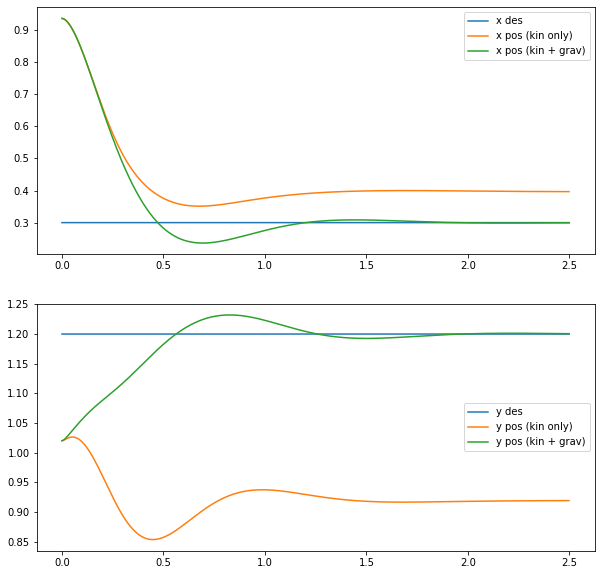

In [ ]:
# Plot x, y of the tip
fig= plt.figure(figsize=(10,10))
keypoints_kin = np.array(key_pts_kin)
keypoints_kin_grav = np.array(key_pts_kin_grav)

ax = plt.subplot(2,1,1)   
...

ax = plt.subplot(2,1,2)   
...

plt.show()

Explain your analysis

# **Q.3. Circular trajectory tracking**

In Q.3., we will let the manipulator follow the circular trajectory instead of stationary target location.

In [ ]:
# Circular desired trajectory: No need to change 
r0 = [0.63, 0.95]
r_circle = 0.3
omega = 2*np.pi*1.5
xee_des_circular = np.zeros((num_step, 9))

for i in range(num_step):
  t = i*dt
  xee_des_circular[i, :] = np.array([r0[0] + r_circle*np.cos(omega*t), r0[1] + r_circle*np.sin(omega*t), np.pi/4, # position
                            -omega*r_circle*np.sin(omega*t), omega*r_circle*np.cos(omega*t), 0, # vel
                            -omega*omega*r_circle*np.cos(omega*t), -omega*omega*r_circle*np.sin(omega*t), 0]) # acc

# **Q.3.(a) [20 pts] Implemente Operational Space Contrller**

Complete the following function returning torque commands based on the formula: 

\begin{equation}
\tau = J^{\top} \left[ \Lambda \left( \ddot{\mathbf r}_C^d + K ({\mathbf r}_C^d - {\mathbf r}_C) + D (\dot{\mathbf r}_C^d - \dot{\mathbf r}_C)\right) + \mu + \rho \right],
\end{equation}

where,

\begin{align}
\Lambda(q)&= (J M^{-1} J^{T})^{-1} \\
\mu(q,\dot{q}) &= \Lambda J M^{-1}\, C - \Lambda \, \dot{J}\, \dot{q}\\
\rho(q) &= \Lambda J M^{-1}\, G
\end{align}

In [ ]:
def OSC_controller(x, params, xee_des, Kp, Kd):
  xp_params = list(x) + list(params)
  # Write your code
  ...
  return u

In [ ]:
# Run simulation: No need to change
ctrl_func = lambda x, params, xee_des: OSC_controller(x, params, xee_des, Kp = 50, Kd = 10)
[ts, x_out_osc, key_pts_osc, _, _, _] = run_simulation(x0, num_step, dt, xee_des_circular, ctrl_func)

# Animation 
anim = visualize_arm(key_pts_osc, xee_des=xee_des_circular, dt = dt, num_frames=200)
plt.close()
HTML(anim.to_html5_video())

# **Q.3.(b) [10 pts] OSC without coriolis effect compensation**

Implement OSC but missing coriolis compensation term.

In [ ]:
def OSC_controller_wo_cori(x, params, xee_des, Kp, Kd):
  xp_params = list(x) + list(params)
  # Write your code
  ...
  
  return u

In [ ]:
# Run simulation: No need to change
ctrl_func = lambda x, params, xee_des: OSC_controller_wo_cori(x, params, xee_des, Kp = 50, Kd = 10)
[ts, x_out_osc_cori, key_pts_osc_wo_cori, _, _, _] = run_simulation(x0, num_step, dt, xee_des_circular, ctrl_func)

# Animation 
anim = visualize_arm(key_pts_osc_wo_cori, xee_des=xee_des_circular, dt = dt, num_frames=200)
plt.close()
HTML(anim.to_html5_video())

# **Q.3.(c) [10 pts] OSC without gravitational force compensation**

Implement OSC without a gravitational force compensation term.

In [ ]:
def OSC_controller_wo_grav(x, params, xee_des, Kp, Kd):
  xp_params = list(x) + list(params)
  # Write your code
  ...
  
  return u

In [ ]:
# Run simulation: No need to change
ctrl_func = lambda x, params, xee_des: OSC_controller_wo_grav(x, params, xee_des, Kp = 50, Kd = 10)
[ts, x_out_osc_grav, key_pts_osc_wo_grav, _, _, _] = run_simulation(x0, num_step, dt, xee_des_circular, ctrl_func)

# Animation
anim = visualize_arm(key_pts_osc_wo_grav, xee_des=xee_des_circular, dt = dt, num_frames=200)
plt.close()
HTML(anim.to_html5_video())

# **Q.3.(d) [15 pts] Plot the tip position along with the target trajectory, and explain the results**

Plot $x$ and $y$ position of the tip using two different controllers and target trajectory together. Analyze and explain the reason for the error and how the gravity term helps the error reduction.

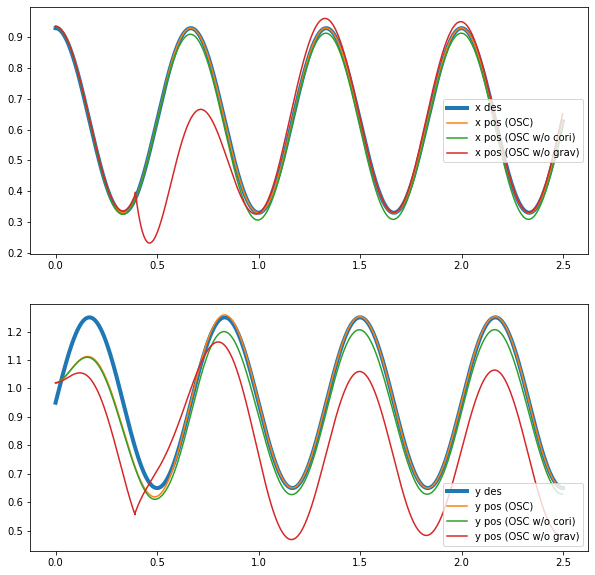

In [ ]:
# Write your code: Plot x, y of the tip
...

Explain your analysis

# (Optional) [10 pts] Try different gain sets and analyze the results based on what we learned in Lecture 17. Feedback control. 

Note: Recommend to use a stationary target rather than moving target.